In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython.display
from PIL import Image
import torch
from torch.utils.data import DataLoader

import beatfinder     # This project
sr = beatfinder.constants.sr
hl = beatfinder.constants.hl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
totensor = beatfinder.model.ToTensor(device)
print(f'Device: {device}')

Device: cpu


In [27]:
offset = 9.4
duration = 10
wav, _ = librosa.load('./data/raw-datasets/SELFMADE/audio/song1.m4a', 
                      offset=offset, duration=duration, sr=sr)

In [28]:
onset_env = librosa.onset.onset_strength(wav, sr=sr, hop_length=hl)[1:]
times = librosa.frames_to_time(np.arange(len(onset_env)), sr, hl)
onset_env -= onset_env.min()
onset_env /= onset_env.max()
onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, hop_length=hl)
onsets_times = librosa.frames_to_time(onsets, sr, hl)

In [40]:
totensor = beatfinder.model.ToTensor(device)
model = beatfinder.model.BeatFinder()
model.load_state_dict(torch.load('./data/pretrained-models/model_11.pt', map_location=device))
model.to(device)
model.eval()
model.freeze()

In [41]:
audiobeats = beatfinder.data.AudioBeats(
    audio_file='./data/raw-datasets/SELFMADE/audio/song1.m4a',
    beats_file='./data/raw-datasets/SELFMADE/beats/song1_excerpt.beats',
    spec_file='./data/tmp/demo/song1_spec.npy',
    onsets_file='./data/tmp/demo/song_1_onsets.csv',
    stretch=1,
    offset=offset,
    duration=duration,
    length=librosa.time_to_samples(duration, sr),
    song_duration=librosa.get_duration(filename='./data/raw-datasets/SELFMADE/audio/song1.m4a'),
    name='demo'
)

In [42]:
audiobeats.precompute()

In [43]:
dataset = beatfinder.data.AudioBeatsDataset([audiobeats], totensor)
model.train()
model.unfreeze()
model.fit(dataset, dataset, epochs=5)
model.eval()
model.freeze()

| 1 | L: 0.951 0.571 | F: 0.250 0.444 | A: 0.483 0.655 | 5.48 s/b | 0:00:05 | ETA: 0:00:21 |
| 2 | L: 0.572 0.473 | F: 0.564 0.739 | A: 0.707 0.793 | 7.85 s/b | 0:00:07 | ETA: 0:00:23 |
| 3 | L: 0.466 0.401 | F: 0.809 0.863 | A: 0.845 0.879 | 6.66 s/b | 0:00:06 | ETA: 0:00:13 |
| 4 | L: 0.404 0.315 | F: 0.833 0.926 | A: 0.862 0.931 | 5.54 s/b | 0:00:05 | ETA: 0:00:05 |
| 5 | L: 0.319 0.213 | F: 0.926 0.963 | A: 0.931 0.966 | 5.29 s/b | 0:00:05 | ETA: 0:00:00 |


In [44]:
ground_truth_beats = audiobeats.get_beats()
onsets_selected, predicted_beats, bpm = beatfinder.utils.predict_beats(model, audiobeats, totensor)

In [45]:
dataset = beatfinder.data.AudioBeatsDataset([audiobeats], totensor)
dataloader = DataLoader(dataset)
sample = iter(dataloader).next()
probs = torch.exp(model(sample[0]).squeeze(0)[:, 1]).cpu().numpy()

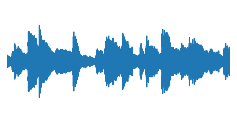

In [46]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
librosa.display.waveplot(wav)
ax.set_xlim(0, 4)
ax.set_ylim(-0.3, 0.3)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/raw_audio.jpg', bbox_inches='tight', pad_inches=0)

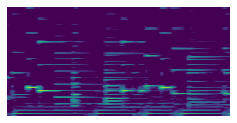

In [47]:
n_mels = 256
fmax = 2**14
n_fft = 2**12
spec = librosa.feature.melspectrogram(wav, sr, hop_length=hl, n_mels=n_mels, fmax=fmax, n_fft=n_fft)**2
spec = librosa.power_to_db(spec)
time = librosa.frames_to_time(np.arange(spec.shape[1]), sr, hl)
freq = librosa.mel_frequencies(n_mels=n_mels)[:n_mels//2]
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.pcolormesh(time, freq, spec[:n_mels//2, :])
ax.set_xlim(0, 4)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/spec.jpg', bbox_inches='tight', pad_inches=0)

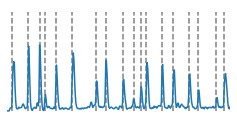

In [48]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
plt.plot(times, onset_env)
plt.vlines(onsets_times, 0, 1.5, color='k', alpha=0.5, linestyles='--', label='onsets')
ax.set_xlim(0, 4)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/onsets.jpg', bbox_inches='tight', pad_inches=0)

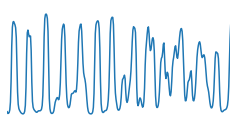

In [49]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
plt.plot(times, probs[:-1])
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/pred.jpg', bbox_inches='tight', pad_inches=0)

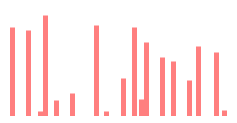

In [55]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
plt.vlines(onsets_times, 0, probs[onsets], color='r', alpha=0.5, linewidths=5)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/beats-probs.jpg', bbox_inches='tight', pad_inches=0)

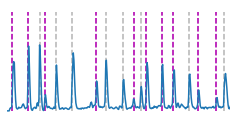

In [56]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
plt.plot(times, onset_env)
plt.vlines(onsets_times, 0, 1.5, color='k', alpha=0.3, linestyles='--')
plt.vlines(onsets_times[probs[onsets] > 0.5], 0, 1.5, color='m', alpha=1, linestyles='--')
ax.set_xlim(0, 4)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/onsets-selected.jpg', bbox_inches='tight', pad_inches=0)

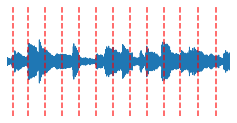

In [59]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
librosa.display.waveplot(wav)
plt.vlines(ground_truth_beats, -0.5, 0.5, color='r', alpha=0.75, linestyles='--', label='ground truth')
ax.set_xlim(0, 4)
ax.set_ylim(-0.5, 0.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/beats-red.jpg', bbox_inches='tight', pad_inches=0)

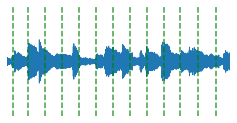

In [60]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
librosa.display.waveplot(wav)
plt.vlines(ground_truth_beats, -0.5, 0.5, color='g', alpha=0.75, linestyles='--', label='ground truth')
ax.set_xlim(0, 4)
ax.set_ylim(-0.5, 0.5)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.savefig('./pictures/beats-green.jpg', bbox_inches='tight', pad_inches=0)